In [10]:
!pip install dahuffman

Defaulting to user installation because normal site-packages is not writeable


In [195]:
"""
Image Processing Laboratory (045108) - Meeting 3/4
Signal and Image Processing Lab (SIPL) & Vision and Image Sciences Lab (VISL)
The Andrew and Enra Viterbi Faculty of Electrical and Computer Engineering
Technion - Israel Institute of Technology
"""

from collections import namedtuple, Counter
import numpy as np
from scipy import fft
from scipy.io import loadmat
from skimage import color, exposure, feature, filters, measure, morphology, io, transform, util
from skimage.color import rgb2hsv, hsv2rgb
import matplotlib.pyplot as plt
from code import flir_image_extractor
import cv2
from skimage.measure import regionprops, label




In [190]:
def visual_prep(filename):
    """
    Prepares an image for the lab by reading, converting to grayscale (if necessary),
    normalizing, and resizing.

    Args:
        filename (str): Path to the image file.

    Returns:
        numpy.ndarray: The prepared image array.
    """

    image = io.imread(filename)
    if len(image.shape) == 3:
       image = color.rgb2gray(image)

    TARGET_WIDTH = 1600
    # Resize the image to TARGET_WIDTH columns keeping the original aspect ratio
    height, width = image.shape
    resize_factor = width / TARGET_WIDTH

    new_height = int(height/resize_factor)
    new_width = TARGET_WIDTH
    image = transform.resize(image, (new_height, new_width), anti_aliasing=True)
    image = util.img_as_ubyte(image)

    return image


def thermal_prep(filename):
    """
    Prepares a FLIR thermal image for the lab by reading it.

    Args:
        filename (str): Path to the FLIR thermal image file.

    Returns:
        numpy.ndarray: The prepared thermal image.
    """

    image_extractor = flir_image_extractor.FlirImageExtractor()
    image_extractor.process_image(filename)
    thermal = image_extractor.extract_thermal_image()

    return thermal


def thermal_prep_uint8(filename):
    """
    Prepares a FLIR thermal image for the lab by reading and converting it to uint8 format.

    Args:
        filename (str): Path to the FLIR thermal image file.

    Returns:
        numpy.ndarray: The prepared thermal image.
    """

    thermal = thermal_prep(filename)

    # Create a copy of the input image
    qth = np.copy(thermal)
    qth = qth.astype(np.float32)

    levels = 256
    # Divide the pixel value range into 'levels' number of buckets
    buckets = np.linspace(THERMAL_MIN_VAL, THERMAL_MAX_VAL, levels + 1)

    # Quantize the image
    count = 0
    for i in range(len(buckets) - 1):
        if i != (len(buckets) - 2):
            qth[(thermal >= buckets[i]) & (thermal < buckets[i + 1])] = count
            count = count + 1
        else:
            qth[(thermal >= buckets[i]) & (thermal <= buckets[i + 1])] = count

    qth = qth.astype(np.uint8)

    return qth


In [3]:
# Laplacian of Gaussian edge detector

def LoG_edge_detection(image, sigma=1.0, threshold=0.1):
    """
    Detects edges in an image using Laplacian of Gaussian detector.

    Args:
        image (np.ndarray): The input image, assumed to be grayscale.
        sigma (float, optional): The standard deviation of the Gaussian filter. Default is 1.0.
        threshold (float, optional): The threshold for edge detection. Default is 0.1.

    Returns:
        np.ndarray: Image with edges.
    """

    blurred = filters.gaussian(image, sigma=sigma, mode='constant', cval=0.0)
    LoG = filters.laplace(blurred)
    th = 10 * np.abs(LoG).mean() * threshold        # Calculate threshold

    output = np.zeros(LoG.shape)
    width = output.shape[1]
    height = output.shape[0]

    for y in range(1, height - 1):
        for x in range(1, width - 1):
            patch = LoG[y-1:y+2, x-1:x+2]           # Get 3x3 patch
            if patch[1,1]<0:                        # Check all cases of [-] in the middle
                if (patch.max()>0) and (patch.max()-patch[1,1]>th):
                    output[y, x] = 1;
            elif patch[1,1]==0:
                if (np.sign(patch[0,1])*np.sign(patch[2,1])<0) and (np.abs(patch[2,1]-patch[0,1])>th): # Check [- 0 +]', [+ 0 -]'
                    output[y, x] = 1;
                if (np.sign(patch[1,0])*np.sign(patch[1,2])<0) and (np.abs(patch[1,2]-patch[1,0])>th): # Check [- 0 +], [+ 0 -]
                    output[y, x] = 1;
                if (np.sign(patch[0,0])*np.sign(patch[2,2])<0) and (np.abs(patch[2,2]-patch[0,0])>th): # Check main diagonal
                    output[y, x] = 1;
                if (np.sign(patch[2,0])*np.sign(patch[0,2])<0) and (np.abs(patch[0,2]-patch[2,0])>th): # Check inverse diagonal
                    output[y, x] = 1;

    return output

In [13]:

#import images
image_blank = visual_prep('images/tetris_blank.jpeg')
image_1 = visual_prep('images/tetris_1.jpeg')
image_2 = visual_prep('images/tetris_2.jpeg')




1.0


Text(0.5, 1.0, 'after edge detection')

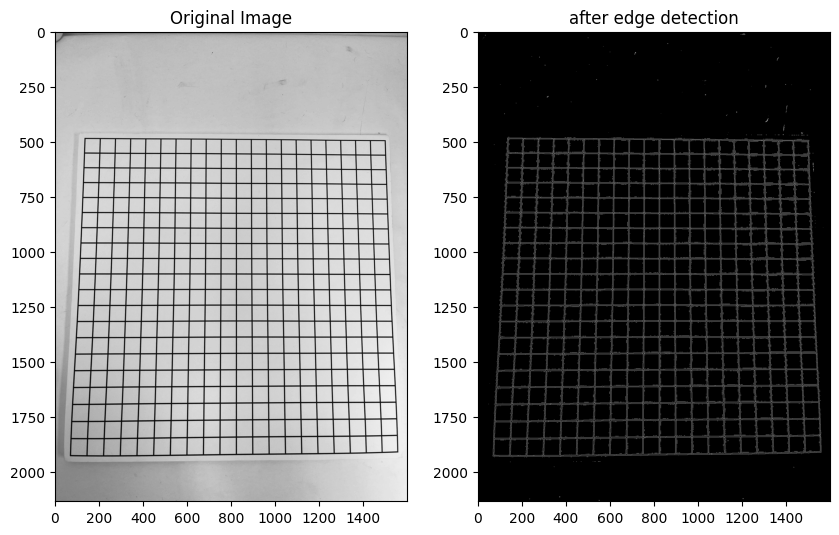

In [172]:
#detect the blank edges
#edges_1 = feature.canny(image_blank, sigma=2.9, low_threshold=50)
edges_1= LoG_edge_detection(image_blank, 1, 0.25)
print(edges_1.max())
edges_1 = np.clip(edges_1, 0, 255).astype(np.uint8)
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
plt.imshow(image_blank, cmap='gray')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(edges_1, cmap='gray')
plt.title('after edge detection')

In [173]:
 

contours, _ = cv2.findContours(edges_1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)


x, y, w, h = cv2.boundingRect(largest_contour)
min_x = x
min_y = y
max_x = x + w
max_y = y + h

edges_coords = {
        'top_left': (min_x, min_y),
        'top_right': (max_x, min_y),
        'bottom_left': (min_x, max_y),
        'bottom_right': (max_x, max_y)
    }

print("Edges of the shape:")
print("Top-left:", edges_coords['top_left'])
print("Top-right:", edges_coords['top_right'])
print("Bottom-left:", edges_coords['bottom_left'])
print("Bottom-right:", edges_coords['bottom_right'])


Edges of the shape:
Top-left: (67, 485)
Top-right: (1556, 485)
Bottom-left: (67, 1931)
Bottom-right: (1556, 1931)


In [174]:
def find_holes_number(image):
       
    # Threshold the image to get binary image
    
    #binary_image = image<10
    #binary_image = binary_image.astype(np.uint8)
    #print(image.min(), image.max(), image.mean(), image.std() )
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY)
    inverted_image = cv2.bitwise_not(binary_image)
    plt.imshow(binary_image, cmap='gray')

   # Find connected components
    num_labels, labels = cv2.connectedComponents(inverted_image, connectivity=8)
    num_holes = num_labels - 1
    
    return num_holes


Number of holes in the grid: 397


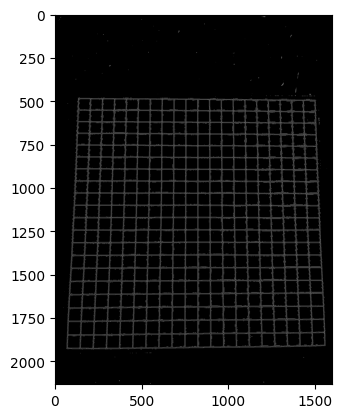

In [175]:
grid = find_holes_number(edges_1)
print("Number of holes in the grid:", grid)

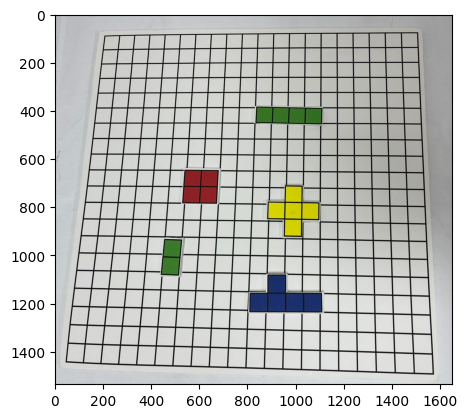

In [219]:
Cimage =  io.imread('images/tetris_1.jpeg');

Cimage = Cimage[0:1600, 100:1750]
plt.imshow(Cimage)

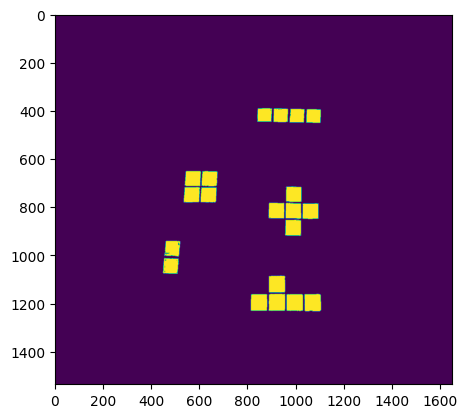

In [220]:
HsV=rgb2hsv(Cimage)
# hue sat val
mask = (
        (HsV[:, :, 0] >= 0) & (HsV[:, :, 0] <= 1) &
        (HsV[:, :, 1] >= 0.6) & (HsV[:, :, 1] <= 1) &
        (HsV[:, :, 2] >= 0.3) & (HsV[:, :, 2] <= 1)
    )

#final= hsv2rgb(mask)
plt.imshow(mask)

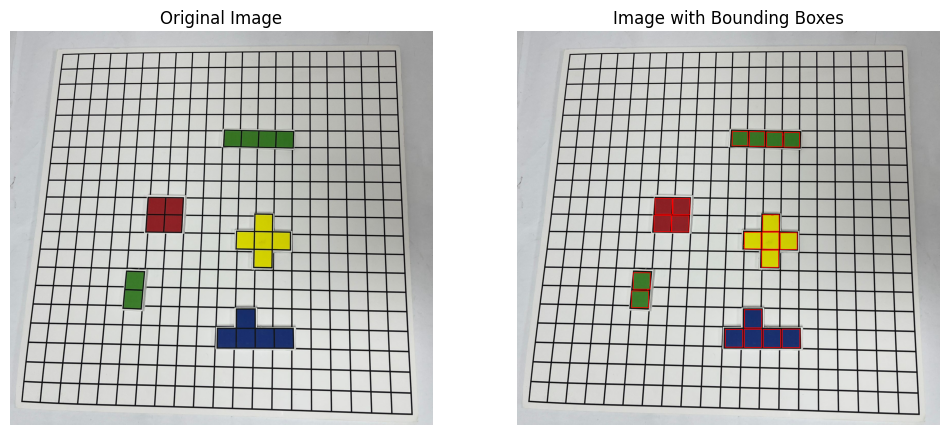

Block 1: Hue: 0.29, Saturation: 0.68, Value: 0.45
Block 2: Hue: 0.29, Saturation: 0.67, Value: 0.45
Block 3: Hue: 0.30, Saturation: 0.67, Value: 0.44
Block 4: Hue: 0.30, Saturation: 0.68, Value: 0.43
Block 5: Hue: 0.30, Saturation: 0.63, Value: 0.32
Block 6: Hue: 0.96, Saturation: 0.60, Value: 0.34
Block 7: Hue: 0.88, Saturation: 0.75, Value: 0.52
Block 8: Hue: 0.90, Saturation: 0.75, Value: 0.53
Block 9: Hue: 0.17, Saturation: 0.96, Value: 0.81
Block 10: Hue: 0.16, Saturation: 0.69, Value: 0.39
Block 11: Hue: 0.92, Saturation: 0.75, Value: 0.53
Block 12: Hue: 0.16, Saturation: 0.69, Value: 0.35
Block 13: Hue: 0.91, Saturation: 0.74, Value: 0.53
Block 14: Hue: 0.00, Saturation: 0.63, Value: 0.34
Block 15: Hue: 0.17, Saturation: 0.96, Value: 0.82
Block 16: Hue: 0.16, Saturation: 0.95, Value: 0.80
Block 17: Hue: 0.16, Saturation: 0.96, Value: 0.80
Block 18: Hue: 0.14, Saturation: 0.61, Value: 0.34
Block 19: Hue: 0.17, Saturation: 0.96, Value: 0.81
Block 20: Hue: 0.30, Saturation: 0.63, V

In [221]:
# Label connected components
labeled_mask = label(mask)
hsv_averages = []

    
    # Get properties of labeled regions
regions = regionprops(labeled_mask)
    
    # Create a copy of the original image to draw bounding boxes
image_with_boxes = Cimage.copy()
    
    # Draw bounding boxes on the image
for region in regions:
        minr, minc, maxr, maxc = region.bbox
        # Draw rectangle
        cv2.rectangle(image_with_boxes, (minc, minr), (maxc, maxr), (255, 0, 0), 2)
        # HSV
        roi = HsV[minr:maxr, minc:maxc]
        
        # Calculate average HSV values
        average_hue = np.mean(roi[:, :, 0])
        average_saturation = np.mean(roi[:, :, 1])
        average_value = np.mean(roi[:, :, 2])
        #push
        hsv_averages.append((average_hue, average_saturation, average_value))
    # Display the results
plt.figure(figsize=(12, 6))
    
plt.subplot(1, 2, 1)
plt.imshow(Cimage)
plt.title('Original Image')
plt.axis('off')
    
plt.subplot(1, 2, 2)
plt.imshow(image_with_boxes)
plt.title('Image with Bounding Boxes')
plt.axis('off')
    
plt.show()

for i, (hue, saturation, value) in enumerate(hsv_averages):
        print(f"Block {i+1}: Hue: {hue:.2f}, Saturation: {saturation:.2f}, Value: {value:.2f}")



(-0.5, 1599.5, 1588.5, -0.5)

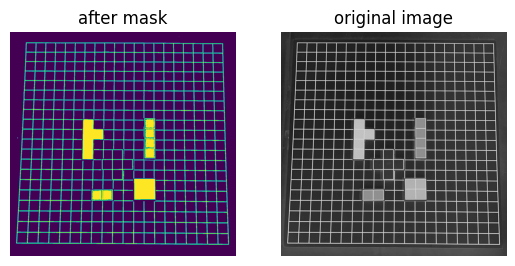

In [263]:
Gimage =  visual_prep('images/tetris_3.jpeg');
Gimage= (Gimage * 255).astype(np.uint8)
maskg = (
        (Gimage[:] <= 10) | (Gimage[:] >= 130)
        
    )

#final= hsv2rgb(mask)
plt.subplot(1, 2, 1)
plt.imshow(maskg)
plt.title('after mask')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(Gimage, cmap='gray')
plt.title('original image')
plt.axis('off')

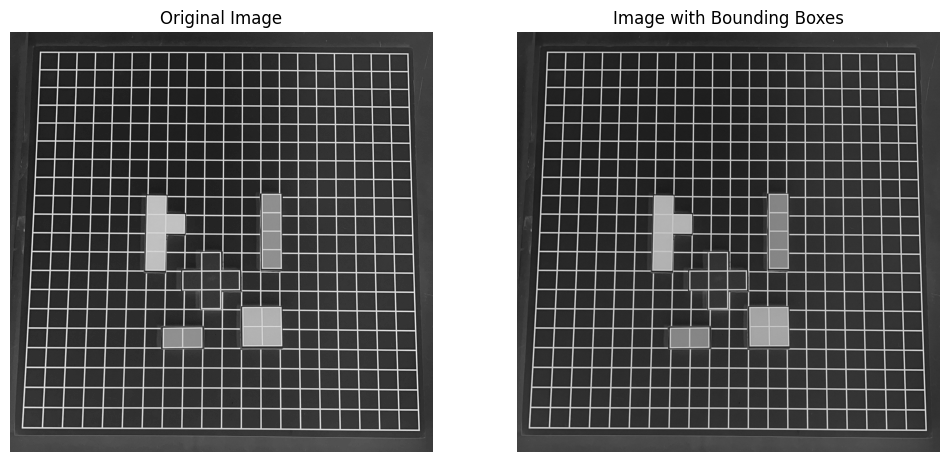

In [264]:
# Label connected components
labeled_maskg = label(maskg)
    
# Get properties of labeled regions
regions = regionprops(labeled_maskg)
    
    # Create a copy of the original image to draw bounding boxes
Gimage_with_boxes = np.stack([Gimage] * 3, axis=-1)
    
    # Draw bounding boxes on the image
for region in regions:
        minr, minc, maxr, maxc = region.bbox
        # Draw rectangle
        cv2.rectangle(image_with_boxes, (minc, minr), (maxc, maxr), (255, 0, 0), 2)
      
    # Display the results
plt.figure(figsize=(12, 6))
    
plt.subplot(1, 2, 1)
plt.imshow(Gimage , cmap='grey')
plt.title('Original Image')
plt.axis('off')
    
plt.subplot(1, 2, 2)
plt.imshow(Gimage_with_boxes , cmap='grey')
plt.title('Image with Bounding Boxes')
plt.axis('off')
    
plt.show()